## Genearting Fake Faces with DCGAN

CelebFaces Attributes (CelebA) Dataset

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import glob # to find allpath names that match specific patterns according to the rules used by the Unix shell
import matplotlib.image as mpimg # for reading an importing images
import seaborn as sns
import os

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator # for data augmentation
from keras.preprocessing.image import load_img # to load an image from a file path and returns a PIL
from keras.preprocessing.image import img_to_array, array_to_img

from keras.models import Model
from keras.models import Sequential

from keras.layers import SeparableConv1D # performs depthwise seperable convolution, includes Depthwise conv and point wise conv --- reduces the number of parameters and computation
from keras.layers import MaxPooling2D, Lambda # to wrap an arbitary function as a layer 
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Input
from keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from keras.layers import LeakyReLU, Activation, Reshape

from keras.utils import plot_model
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint # to save the model's weight at specific points, such as after each epoch
from keras.callbacks import ReduceLROnPlateau # to adjust the LR of the optimizer during training. It monitors the validation loss and reduces the LR

2023-08-27 21:36:40.099249: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-27 21:36:40.100625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 21:36:40.137558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 21:36:40.138125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 21:36:40.683631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
attributes = pd.read_csv('Dataset/list_attr_celeba.csv')
bboxes = pd.read_csv('Dataset/list_bbox_celeba.csv')
partition = pd.read_csv('Dataset/list_eval_partition.csv')
landmarks = pd.read_csv('Dataset/list_landmarks_align_celeba.csv')

base_directory = 'Dataset/img_align_celeba/'

/tmp/ipykernel_13287/3801893849.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


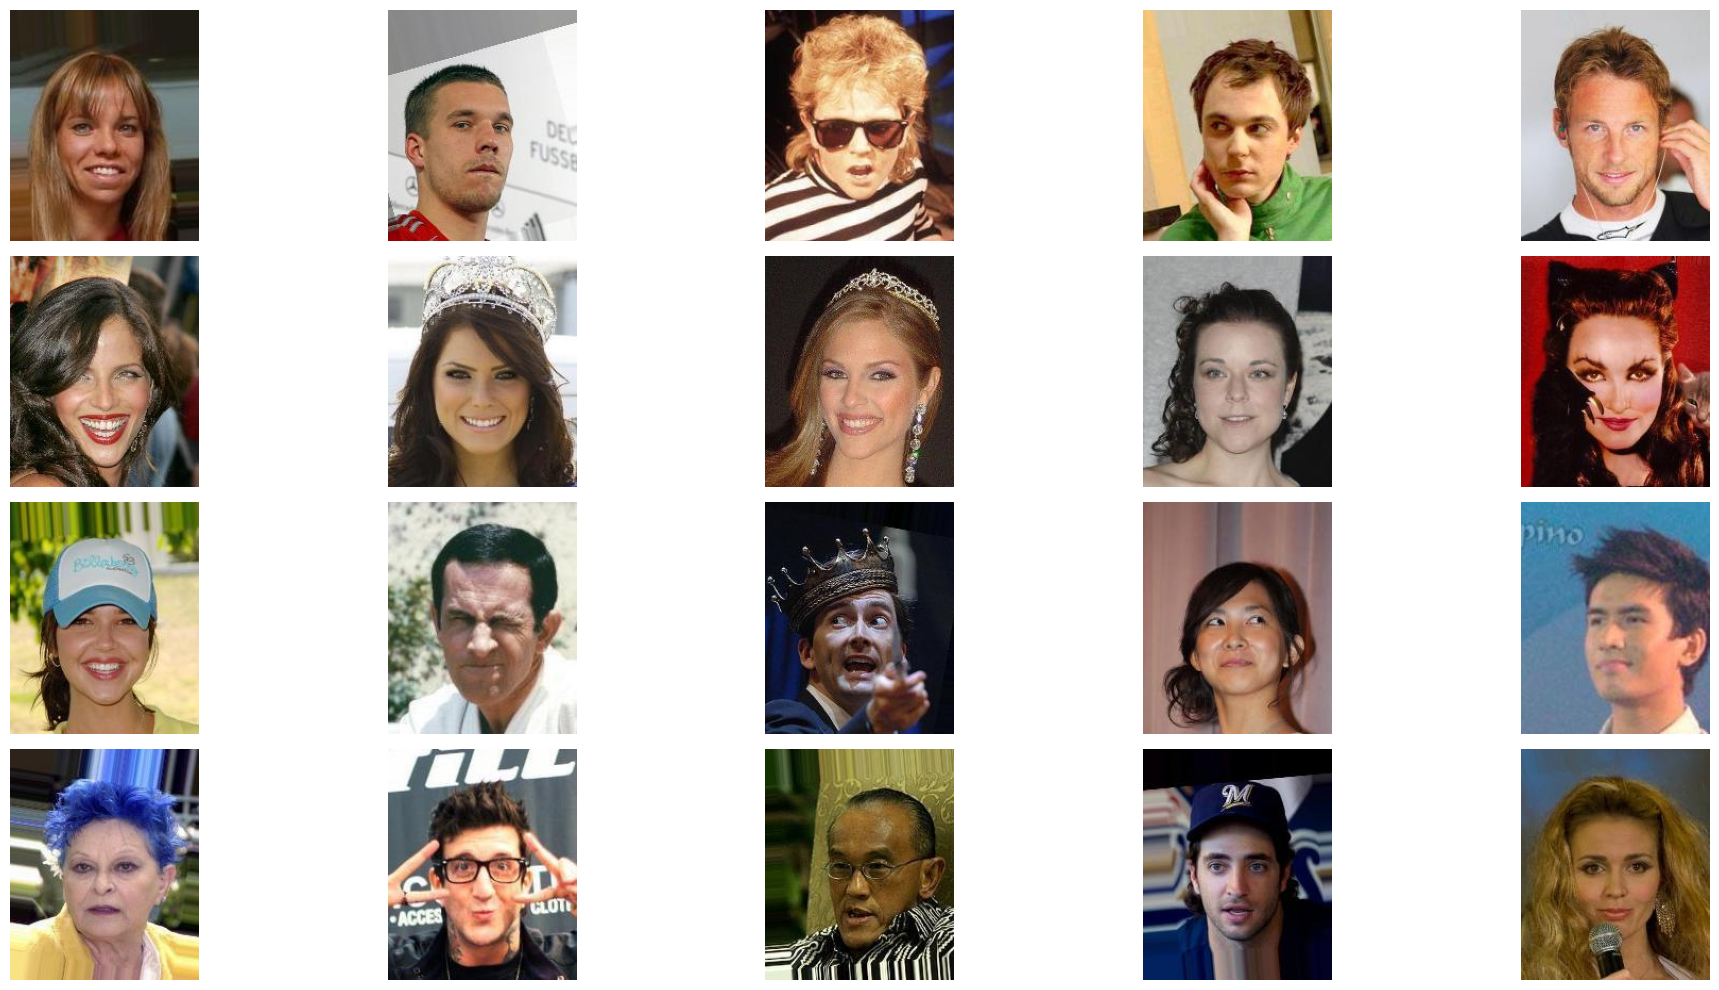

In [3]:
images = []
num_images_to_load = 20

for img_path in glob.glob('Dataset/img_align_celeba/img_align_celeba/*.jpg')[:num_images_to_load]:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20, 10))
columns = 5

for i, image in enumerate(images):
    plt.subplot(len(images)//columns, columns, i+1) # rows, cols, image position in the grid
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image)
    
plt.show()


### Reading list_landmarks_align_celeba.csv

In [4]:
landmarks_df = pd.read_csv('Dataset/list_landmarks_align_celeba.csv')
landmarks_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


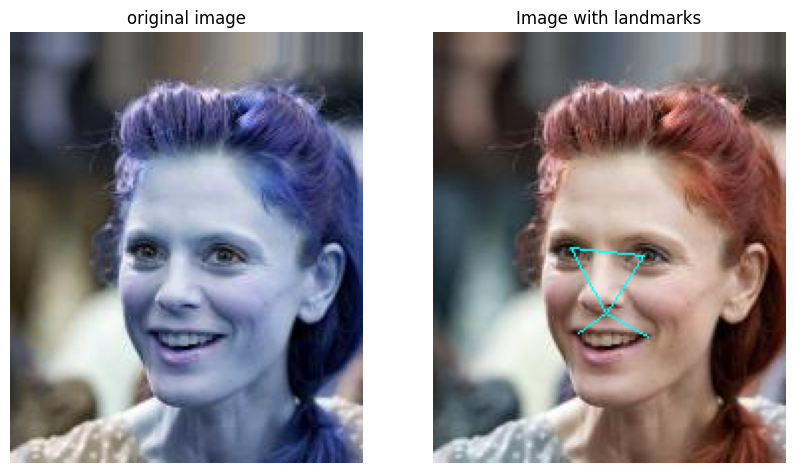

In [5]:
## Plotting Landmarks

paths_to_images = 'Dataset/img_align_celeba/img_align_celeba/000002.jpg'

eye_x, eye_y, eye_w, eye_h = np.array(landmarks.iloc[:, 1:5])[0]
nose_x,	nose_y,	leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y = np.array(landmarks.iloc[:, 5:])[0]


left_eye = (eye_x, eye_y)
right_eye = (eye_w, eye_h)
nose = (nose_x + 10,nose_y)
left_mounth = (leftmouth_x, leftmouth_y)
right_mounth = (rightmouth_x, rightmouth_y)

example_image = cv2.imread(paths_to_images)
original_image = example_image.copy()

example_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)


example_image = cv2.line(example_image, left_eye, right_eye, (0, 255, 255),1)
example_image = cv2.line(example_image, left_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, right_eye, nose, (0, 255, 255), 1)
example_image = cv2.line(example_image, nose, left_mounth,(0, 255, 255), 1)
example_image = cv2.line(example_image, nose, right_mounth, (0, 255, 255), 1)


plt.figure(figsize = (10, 20))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(original_image)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Image with landmarks')
plt.imshow(example_image)


### Reading Bounding Box coordinates list_bbox_celeba.csv

In [6]:
bboxes_df = pd.read_csv('Dataset/list_bbox_celeba.csv')
bboxes_df.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


### Reading list_eval_partition.csv

In [7]:
partition_df = pd.read_csv('Dataset/list_eval_partition.csv')
partition_df.head()


,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [8]:
# Types of Partition

partition_df['partition'].value_counts()

partition
0    162770
2     19962
1     19867
Name: count, dtype: int64

In [9]:
train_images = partition.query('partition == 0')
valid_images = partition.query('partition == 1')
test_images = partition.query('partition == 2')

### Reading list_attr_celeba.csv

In [10]:
attributes_df = pd.read_csv('Dataset/list_attr_celeba.csv')
attributes_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## Discriminator

In [11]:
discriminator = Sequential(
    [
        Input(shape=(64, 64, 3)),
    
        Conv2D(filters=64, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.2),
        Dense(units=1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

2023-08-27 21:36:44.377020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 21:36:44.377370: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
latent_dim = 100

generator = Sequential(
    [
        Input(shape=(latent_dim)),
        
        Dense(units=8*8*128),
        Reshape(target_shape=(8, 8, 128)),
        
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(filters=3, kernel_size=5, padding='same', activation='sigmoid'),        
    ],
    name='generator',
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset", label_mode=None, image_size=(64, 64), batch_size=32
)

dataset = dataset.map(lambda x: x/255.0)

Found 202599 files belonging to 1 classes.


## Override Train Step

In [17]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Create a callback that periodically saves generated images

In [18]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            plt.show()

### Train the End-to-End model

In [ ]:
from tensorflow import keras

epochs = 50

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

In [21]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [22]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('output_samples/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 20
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    #fig.tight_layout() 
    plt.imshow(image)

<Figure size 2000x1000 with 0 Axes>